In [1]:
import jax
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt


from functools import partial

In [2]:
sns.set_palette("colorblind")
%config InlineBackend.figure_format = "retina"

In [3]:
plt.rcParams["figure.figsize"] = (7.2, 3.0)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def step_ssm(theta, key, F, H, Q, R):
    key_latent, key_obs = jax.random.split(key)


    dim_obs, dim_latent = H.shape
    noise_latent = jax.random.normal(key_latent, (dim_latent,)) @ jnp.linalg.cholesky(Q)
    noise_obs = jax.random.normal(key_obs, (dim_obs,)) @ jnp.linalg.cholesky(R)
    
    theta = F @ theta #+ noise_latent
    # Build observation 
    y = H @ theta + noise_obs

    out = {
        "y": y,
        "theta": theta,
        "ut": noise_obs
    }

    return theta, out

In [6]:
def kf_step(bel, y, H, F, R, Q):
    """
    jax.lax.scan compatible step function to run the
    Kalman filter with constant dynamics.
    """
    mu, Sigma = bel

    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q

    # Innovation, variance of innvation, and the Kalman gain
    err =  y - H @ mu_pred
    S = H @ Sigma_pred @ H.T + R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T

    # Update
    mu = mu_pred + K @ err
    Sigma = Sigma_pred - K @ S @ K.T

    bel_next = (mu, Sigma)
    out = {
        "mu": mu,
        "err": err,
        "yhat": H @ mu_pred
    }

    return bel_next, out


In [25]:
def wolf_step(bel, y, H, F, R, Q, c=3.0):
    """
    jax.lax.scan compatible step function to run the
    Kalman filter with constant dynamics.
    """
    mu, Sigma = bel

    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q

    # Innovation, variance of innvation, and the Kalman gain
    err =  y - H @ mu_pred
    wt = 1 / jnp.sqrt(1 + jnp.linalg.norm(err) ** 2 / c)
    S = H @ Sigma_pred @ H.T + R / wt
    K = jnp.linalg.solve(S, H @ Sigma_pred).T

    # Update
    mu = mu_pred + K @ err
    Sigma = Sigma_pred - K @ S @ K.T

    bel_next = (mu, Sigma)
    out = {
        "mu": mu,
        "err": err,
        "yhat": H @ mu_pred,
        "wt": wt,
    }

    return bel_next, out


In [26]:
key = jax.random.PRNGKey(314)
key_F, key_sample = jax.random.split(key)

In [27]:
F = jax.random.orthogonal(key_F, 2)
H = jnp.eye(2)
Q = jnp.eye(2) * 1e-5
R = jnp.eye(2) * 0.1

In [28]:
theta = jnp.pi  * 0.2
F = jnp.array([
    [jnp.cos(theta), -jnp.sin(theta)],
    [jnp.sin(theta), jnp.cos(theta)]
])

In [29]:
n_steps = 20
steps = jnp.arange(n_steps)
_step = partial(step_ssm, F=F, Q=Q, H=H, R=R)
keys = jax.random.split(key_sample, n_steps)

theta = jnp.ones(2)
_, hist = jax.lax.scan(_step, theta, keys)

In [53]:
mu = jnp.zeros(2)
Sigma = jnp.eye(2)
state = (mu, Sigma)

In [62]:
y = hist["y"].at[10].set(20.0)


_step = partial(kf_step, H=H, F=F, R=R, Q=Q)
_, hist_filter_kf = jax.lax.scan(_step, state, y)

_step = partial(wolf_step, H=H, F=F, R=R, Q=Q, c=3.0)
_, hist_filter_wolf = jax.lax.scan(_step, state, y)

In [63]:
u_hist = hist["ut"][:, 1].at[10].set(20.0)

def naive_step(theta, u):
    theta_next = F @ theta + u
    return theta_next, theta_next

_, hist_naive = jax.lax.scan(naive_step, theta, u_hist)

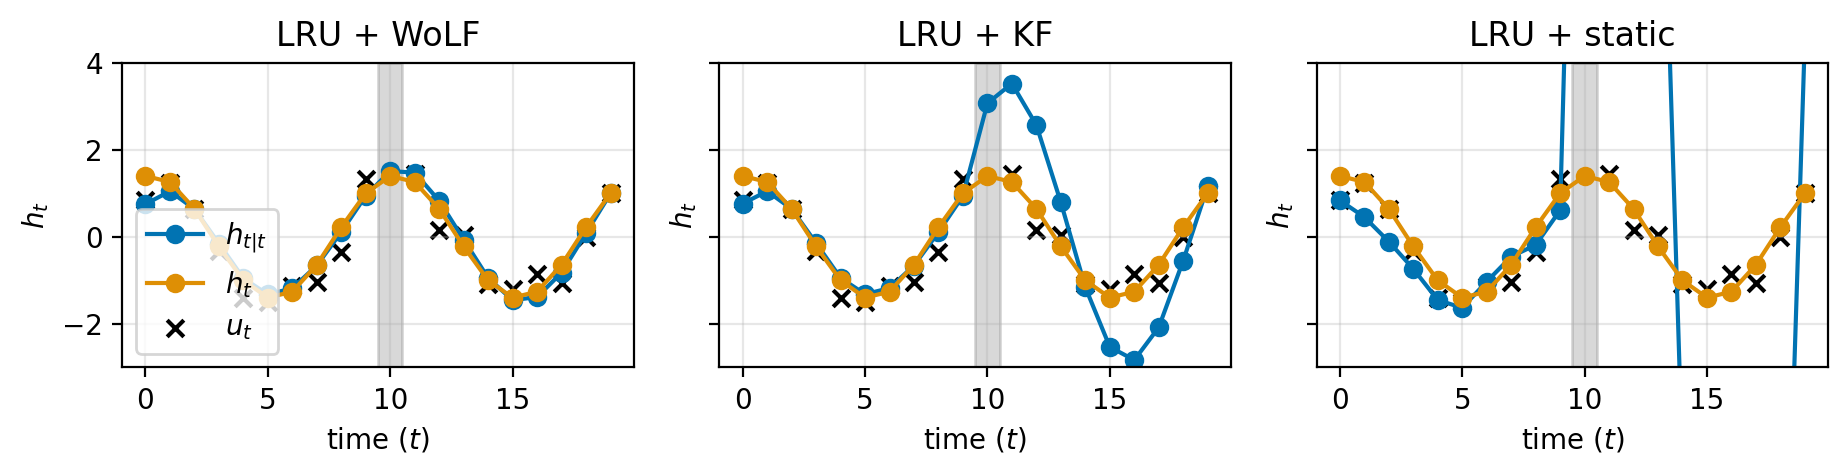

In [66]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(7.2 * 1.3, 2.5))
ax[0].plot(hist_filter_wolf["mu"][:, 1], marker="o", label="$h_{t|t}$")
ax[1].plot(hist_filter_kf["mu"][:, 1], marker="o", label="$h_{t|t}$")
ax[2].plot(hist_naive[:, 1], marker="o", label="$h_{t|t}$")

ax[0].set_title("LRU + WoLF")
ax[1].set_title("LRU + KF")
ax[2].set_title("LRU + static")

for axi in ax:
    plt.sca(axi)
    axi.plot(hist["theta"][:, 1], marker="o", label="$h_t$")
    axi.scatter(steps, y[:, 1], marker="x", label="$u_t$", c="black")
    axi.axvspan(9.5, 10.5, color="tab:gray", alpha=0.3)

    plt.xlabel("time ($t$)")
    plt.ylabel("$h_t$")
    plt.grid(alpha=0.3)

    plt.ylim(-3, 4)
ax[0].legend(ncol=1, loc="lower left")
plt.tight_layout()
plt.savefig("KF-sinusoisal.png", dpi=300, bbox_inches="tight")

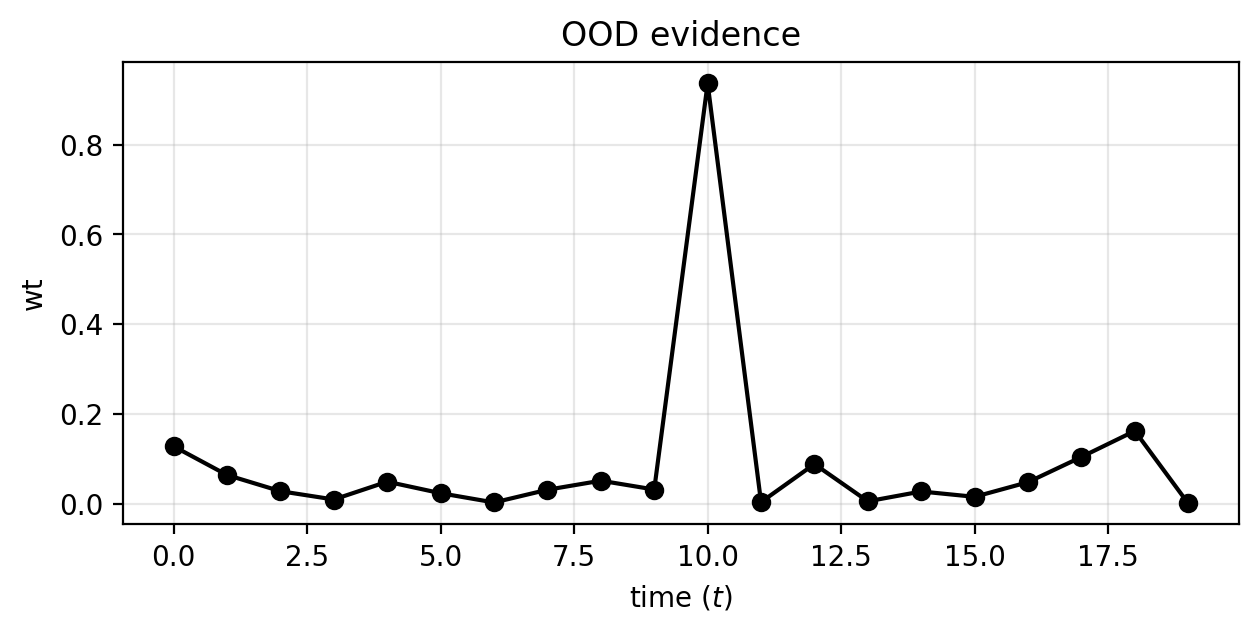

In [48]:
plt.plot(1 - hist_filter_wolf["wt"], c="black", marker="o")
plt.title("OOD evidence")
plt.ylabel("wt")
plt.xlabel("time ($t$)")
plt.grid(alpha=0.3)

## Stability

In [134]:
F

Array([[-0.98554397,  0.16941956],
       [-0.16941956, -0.985544  ]], dtype=float32)

(-1.0994713455438614,
 1.0999748259782791,
 -1.0998615264892577,
 1.0998615264892577)

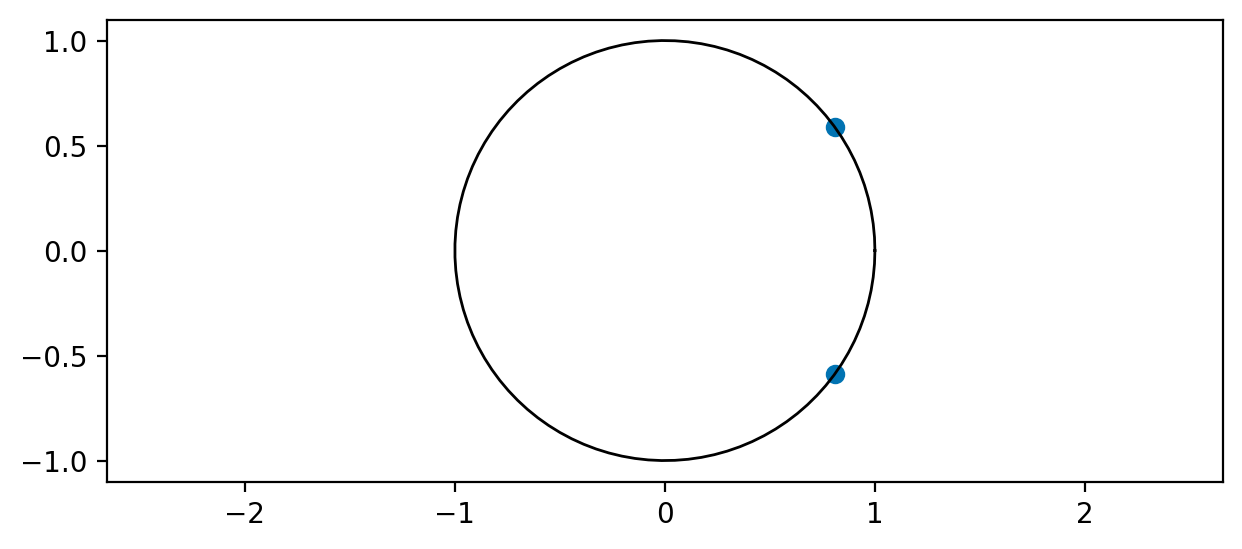

In [58]:
t = jnp.linspace(0,jnp.pi*2,100)
plt.plot(jnp.cos(t), jnp.sin(t), linewidth=1, color='k')

plt.scatter(jnp.linalg.eigvals(F).real, jnp.linalg.eigvals(F).imag)
plt.axis("equal")